# Exploring the demonstration models

This notebook shows several standard ways to interact with the demonstrations stored into the exp/run directories. 

In [1]:
import sys
sys.path.append("..")
from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import cv2

import matplotlib.pyplot as plt
import random
import torch
import json

import pathlib
from demonstration import Demonstration, list_demos, select_demo

In [2]:
experiment = "demonstration"
run = "freeform"

exp = Config().get_experiment(experiment, run)

***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml
***ExpRun**: Experiment default config C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\demonstration\_demonstration.yaml was empty, ok.
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\demonstration\freeform_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: demonstration/freeform successfully loaded


### Read out all the demonstrations from a run

In [3]:
# read out all the demonstrations from a run
#demos = [item.name for item in exp.data_dir().iterdir() if item.is_dir()]
demos = list_demos(exp)
print(demos)

['2024_12_26__16_40_20', '2024_12_26__16_44_06', 'testing']


In [4]:
demo = select_demo(exp)

A pop up dialog will appear now. Enter the number of demonstration.
	0: 2024_12_26__16_40_20
	1: 2024_12_26__16_44_06
	2: testing
You chose demonstration: testing


###  Read out all the pictures in the demonstration

{'cameras': ['dev2'],
 'demo': 'testing',
 'demo_dir': WindowsPath('c:/Users/lboloni/Documents/Code/_TempData/BerryPicker-experiments/demonstration/freeform/testing'),
 'exp': Experiment: {'experiment_name': 'demonstration', 'name': 'freeform', 'cameras': {'all': {'fps': 10, 'width': 256, 'height': 256}}, 'run_name': 'freeform', 'exp_run_sys_indep_file': 'C:\\Users\\lboloni\\Documents\\Code\\_Checkouts\\BerryPicker\\src\\experiment_configs\\demonstration\\freeform.yaml', 'data_dir': 'c:\\Users\\lboloni\\Documents\\Code\\_TempData\\BerryPicker-experiments\\demonstration\\freeform', 'subrun_name': None, 'time_started': '2025-05-14 07:57:07'},
 'maxsteps': 596,
 'videocap': {}}
Cameras found: ['dev2']
There are 596 steps in this demonstration
This demonstration was recorded by the following cameras: ['dev2']


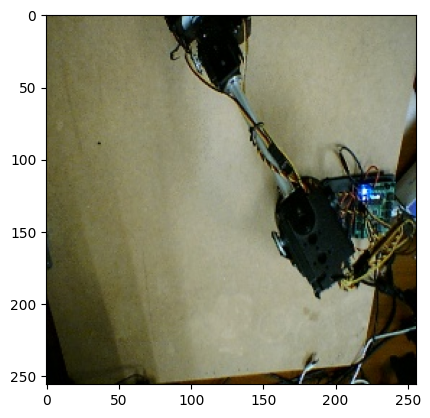

In [5]:
demo = Demonstration(exp, demo)
print(demo)
print(f"Cameras found: {demo.cameras}")
print(f"There are {demo.maxsteps} steps in this demonstration")
print(f"This demonstration was recorded by the following cameras: {demo.cameras}")

# pick and show a random image from a random camera
cam = random.choice(demo.cameras)
imgno = random.randint(0, demo.maxsteps)
sensor_readings, image = demo.get_image(imgno, camera=cam)

fig, ax = plt.subplots()
ax.imshow(image)


# Move all the figures to a video

In [6]:
def move_to_video_per_camera(demo: Demonstration, cam, delete_img_files = False):
    """Move the content of a specific camera into video"""
    if cam in demo.exp["cameras"]:
        params = demo.exp["cameras"][cam]
    else:
        params = demo.exp["cameras"]["all"]
    video_path = demo.get_video_path()
    image_paths = []
    # Initialize video writer
    if not video_path.exists():
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, params["fps"], (params["width"], params["height"]))
        for i in range(1, demo.maxsteps):
            img_path = demo.get_image_path(i, camera=cam)
            image_paths.append(img_path)
            frame = cv2.imread(str(img_path))
            out.write(frame)
        out.release()
    # if specified, delete the image files
    if delete_img_files:
        for img_path in image_paths:
            img_path.unlink()

In [7]:
def move_to_video(demo: Demonstration, delete_img_files = False):
    """Moves to the video the content all all cameras"""
    for cam in demo.cameras:
        move_to_video_per_camera(demo, cam, delete_img_files)

In [ ]:
from sensorprocessing.sp_helper import load_capture_to_tensor

def get_image_from_video(demo: Demonstration, i, camera=None, cache=False):
    """Extracts an image from the video. 
    FIXME: this function opens the video file, seeks and closes it, so it should be very inefficient, we should store the open one in the demonstration instead
    If cache is False, the function closes the open file
    """
    if camera is None:
        camera = demo.cameras[0]    
    if camera not in demo.videocap:    
        video_path = demo.get_video_path(camera)
        cap = cv2.VideoCapture(video_path)
        # demonstration pics start at 1, but cv2 starts at 0        
        cap.set(cv2.CAP_PROP_POS_FRAMES, i - 1) 
        demo.videocap[camera] = cap
    else:
        cap = demo.videocap[camera]
    ret, frame = cap.read()
    if ret:
        # CV2 reads by default in BGR... 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # cv2.imwrite(output_image, frame)    
        image_to_process, image_to_show = load_capture_to_tensor(frame, transform=None)
    else:
        print(f"Could not read frame {i}")
        image_to_process = None
        image_to_show = None
    if not cache:
        demo.videocap[camera].release()
        demo.videocap.pop(camera)
    return image_to_process, image_to_show        

Image number: 318


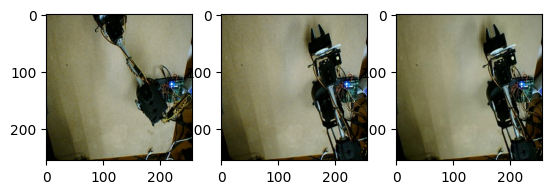

In [13]:
imgno = random.randint(0, demo.maxsteps)
print(f"Image number: {imgno}")
vid_tensor, vid_image = get_image_from_video(demo, imgno)

img_tensor, img_image = demo.get_image(imgno+1, camera=cam)

fig, [ax1, ax2, ax3] = plt.subplots(1,3)
ax1.imshow(image)
ax3.imshow(vid_image)
ax2.imshow(img_image)


In [14]:
vid_tensor - img_tensor

tensor([[[[-0.0078, -0.0039, -0.0314,  ..., -0.0078, -0.0196,  0.0039],
          [ 0.0039, -0.0039, -0.0275,  ..., -0.0118, -0.0196,  0.0039],
          [ 0.0078, -0.0039, -0.0196,  ..., -0.0118, -0.0157, -0.0078],
          ...,
          [-0.0039, -0.0039,  0.0000,  ..., -0.0078,  0.0000, -0.0039],
          [ 0.0000,  0.0000, -0.0039,  ..., -0.0118,  0.0000,  0.0039],
          [ 0.0039,  0.0000, -0.0039,  ..., -0.0039, -0.0039, -0.0157]],

         [[ 0.0078,  0.0078, -0.0118,  ..., -0.0039, -0.0157,  0.0078],
          [ 0.0157,  0.0078, -0.0078,  ..., -0.0078, -0.0157,  0.0078],
          [ 0.0196,  0.0078, -0.0118,  ..., -0.0039, -0.0078, -0.0039],
          ...,
          [-0.0039, -0.0039,  0.0000,  ...,  0.0039, -0.0039, -0.0118],
          [ 0.0000,  0.0000, -0.0039,  ..., -0.0039,  0.0000,  0.0000],
          [ 0.0039,  0.0000, -0.0039,  ...,  0.0000,  0.0000, -0.0157]],

         [[-0.0353, -0.0235, -0.0235,  ..., -0.0039, -0.0078,  0.0157],
          [-0.0157, -0.0157, -

In [11]:
# move_to_video(demo, delete_img_files=True)
move_to_video(demo, delete_img_files=False)